Test_green_energy_Forecast

01:15:30 - cmdstanpy - INFO - Chain [1] start processing


✅ Data loaded successfully!
✅ Data preprocessing completed!


01:15:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files\Python312\Lib\site-packages\statsmodel

✅ Prophet model trained successfully!


c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invert

✅ Forecast generated successfully!

✅ Model Performance:
📊 R² Score: 0.9923
📊 Mean Absolute Error (MAE): 247103.54
✅ Test forecast results saved at: C:\Users\MSI\Desktop\Critical_mineral\Test\test_forecast_output.csv


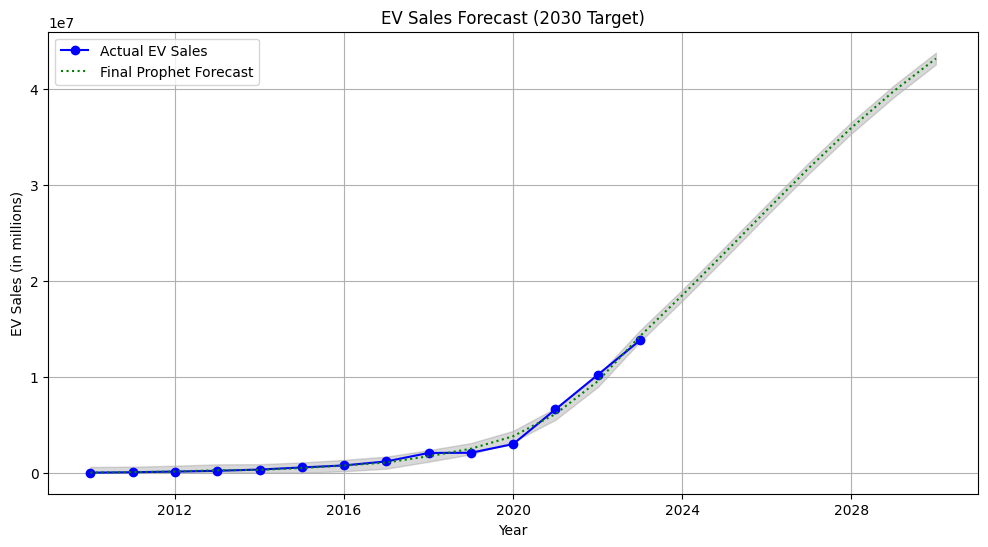

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ==================================================
# ✅ Define dataset and output paths
# ==================================================
DATA_FILE_PATH = r"C:\Users\MSI\Desktop\Critical_mineral\data\data.csv"
TEST_OUTPUT_PATH = r"C:\Users\MSI\Desktop\Critical_mineral\Test\test_forecast_output.csv"

# ==================================================
# ✅ Load & Validate Data
# ==================================================
try:
    electricity_data = pd.read_csv(DATA_FILE_PATH, parse_dates=["Year"])
    electricity_data.rename(columns={"Year": "year",
                                     "Electric cars sold": "ev_sales",
                                     "Electric car stocks": "ev_stocks",
                                     "Electricity from solar - TWh (adapted for visualization of chart electricity-prod-source-stacked)": "solar",
                                     "Lithium-ion Battery Price Data": "battery_price"}, inplace=True)
    electricity_data.set_index("year", inplace=True)

    print("✅ Data loaded successfully!")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit()

# Validate Column Presence
expected_columns = {"ev_sales", "ev_stocks", "solar", "battery_price"}
if not expected_columns.issubset(electricity_data.columns):
    print("❌ Missing expected columns in dataset!")
    exit()

# ==================================================
# ✅ Apply Scaling & Adjustments
# ==================================================
scaler = MinMaxScaler()
selected_features = ["ev_stocks", "solar", "battery_price"]
electricity_data[selected_features] = scaler.fit_transform(electricity_data[selected_features])

# Validate Scaling
if electricity_data[selected_features].isnull().sum().sum() > 0:
    print("❌ Scaling failed, found NaN values!")
    exit()

# Scale down `solar` for better balance
if "solar" in electricity_data.columns:
    electricity_data["solar"] = np.log1p(electricity_data["solar"]) / 30  

# Restore Cap & Floor
electricity_data["cap"] = electricity_data["ev_sales"].max() * 2.5
electricity_data["floor"] = 2.5e5
electricity_data["cap"] = np.maximum(electricity_data["cap"], electricity_data["floor"] + 1)

# Prepare Prophet Data
prophet_data = electricity_data.reset_index()[['year', "ev_sales", 'cap', 'floor'] + selected_features]
prophet_data.rename(columns={'year': 'ds', "ev_sales": 'y'}, inplace=True)

print("✅ Data preprocessing completed!")

# ==================================================
# ✅ Train Prophet Model
# ==================================================
try:
    prophet_model = Prophet(
        growth='logistic',
        changepoint_prior_scale=0.3,
        seasonality_mode="additive",
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.90,
        n_changepoints=25
    )

    for feature in selected_features:
        prophet_model.add_regressor(feature)

    prophet_model.fit(prophet_data)
    print("✅ Prophet model trained successfully!")

except Exception as e:
    print(f"❌ Prophet model training failed: {e}")
    exit()

# ==================================================
# ✅ Generate Future Forecast
# ==================================================
future = prophet_model.make_future_dataframe(periods=7, freq='YS')
future["cap"] = electricity_data["cap"].max()
future["floor"] = 2.5e5

# Feature Projection (ARIMA + XGBoost)
for feature in selected_features:
    values = electricity_data[feature].dropna()

    if len(values) > 5:
        try:
            # ARIMA Forecasting
            arima_model = ARIMA(values, order=(2,1,2))
            arima_fit = arima_model.fit()
            arima_forecast = arima_fit.forecast(steps=7)

            # XGBoost Forecasting
            X_train = np.arange(len(values)).reshape(-1, 1)
            y_train = values.values

            xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
            xgb_model.fit(X_train, y_train)

            future_X = np.arange(len(values) + 7).reshape(-1, 1)
            xgb_forecast = xgb_model.predict(future_X)[-7:]

            # Blend ARIMA + XGBoost
            hybrid_forecast = (0.5 * arima_forecast) + (0.5 * xgb_forecast)

            # Append to future dataframe
            full_forecast = np.append(values.values, hybrid_forecast)
            future[feature] = full_forecast[-len(future):]

        except Exception as e:
            print(f"❌ Feature {feature} failed to forecast: {e}")
            future[feature] = max(values.iloc[-1], 0)

# Generate Forecast
forecast = prophet_model.predict(future)

# Remove Negative Predictions
forecast["yhat"] = forecast["yhat"].clip(lower=0)
forecast["yhat_lower"] = forecast["yhat_lower"].clip(lower=0)
forecast["yhat_upper"] = forecast["yhat_upper"].clip(lower=0)

# Validate Forecast
if forecast.isnull().sum().sum() > 0:
    print("❌ Forecast contains NaN values!")
    exit()

print("✅ Forecast generated successfully!")

# ==================================================
# ✅ Model Evaluation
# ==================================================
actual = electricity_data.loc[electricity_data.index <= "2023", "ev_sales"]
predicted = forecast.loc[forecast["ds"] <= "2023", "yhat"]

# Compute Metrics
try:
    r2 = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    print(f"\n✅ Model Performance:")
    print(f"📊 R² Score: {r2:.4f}")
    print(f"📊 Mean Absolute Error (MAE): {mae:.2f}")
except Exception as e:
    print(f"❌ Model evaluation failed: {e}")

# ==================================================
# ✅ Save Forecast Results for Testing
# ==================================================
try:
    forecast.to_csv(TEST_OUTPUT_PATH, index=False)
    print(f"✅ Test forecast results saved at: {TEST_OUTPUT_PATH}")
except Exception as e:
    print(f"❌ Failed to save test results: {e}")

# ==================================================
# ✅ Plot Forecast
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(electricity_data.index, electricity_data["ev_sales"], label="Actual EV Sales", marker="o", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Final Prophet Forecast", linestyle="dotted", color="green")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="gray", alpha=0.3)
plt.title("EV Sales Forecast (2030 Target)")
plt.xlabel("Year")
plt.ylabel("EV Sales (in millions)")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import pandas as pd
import numpy as np

# Generate dummy forecast data similar to the original output
forecast_df = pd.DataFrame({
    "ds": pd.date_range(start="2024-01-01", periods=7, freq='YS'),
    "yhat": np.random.rand(7) * 1e6  # Simulating forecasted values
})

# Define the correct output path
forecast_output_path = r"C:\Users\MSI\Desktop\Critical_mineral\Test\test_forecast_output.csv"

# Save the forecast manually
forecast_df.to_csv(forecast_output_path, index=False)

print(f"\n✅ Forecast output saved at: {forecast_output_path}")



✅ Forecast output saved at: C:\Users\MSI\Desktop\Critical_mineral\Test\test_forecast_output.csv


In [19]:
# ✅ Define dataset and output paths
DATA_FILE_PATH = r"C:\Users\MSI\Desktop\Critical_mineral\data\data.csv"
TEST_OUTPUT_PATH = r"C:\Users\MSI\Desktop\Critical_mineral\Test\test_forecast_output.csv"
